In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
exp_matrix <-
    read_xlsx('counts raw chondrosarcoma.xlsx', sheet='TargetCountMatrix') %>%
    filter(!str_detect(`TargetName`, '^TR[ABDG][JVC][0-9]*'))

exp_matrix %>%
    head()

TargetName,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RFC3,1.245731,1.741101,1.319508,1.148698,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.000000,1,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1,1.319508,1,1,1.000000,⋯,1.148698,2.605171,1.643752,1,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1,1.245731,1,1,1.000000,⋯,1.319508,4.324246,1.148698,1,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.430969,1,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1,1.000000,1,1,1.148698,⋯,1.430969,4.042823,1.148698,1,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1,1.000000,1,1,1.000000,⋯,1.245731,3.758480,1.000000,1,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731


In [3]:
tumor_vs_peritumor <-
    read_xlsx('normalized raw chondrosarcoma.xlsx', sheet='TargetCountMatrix', n_max=1, col_names=paste('c', 1:141, sep='_')) %>%
    t()

tumor_vs_peritumor %>%
    head()

c_1,tumor
c_2,tumor
c_3,tumor
c_4,tumor
c_5,peritumor
c_6,peritumor


In [4]:
sample_annotations <-
    tibble(
        `sample_desc`=exp_matrix %>% select(-`TargetName`) %>% colnames(),
        `region_type`=tumor_vs_peritumor %>% as.vector()
    ) %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

sample_annotations %>%
    head()

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor


In [5]:
exp_tbl <-
    exp_matrix %>%
    pivot_longer(
        names_to='sample_desc',
        values_to='norm_exp',
        -`TargetName`
    ) %>%
    left_join(sample_annotations, by='sample_desc') %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    relocate(`region_type`, .after=`region_id`) %>%
    rename(`gene_symbol`=`TargetName`) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    )) %>%
    group_by(`gene_symbol`, `sample_name`, `region_type`) %>%
    summarize(`total_exp`=sum(`norm_exp`), .groups='drop')

exp_tbl %>%
    head()

gene_symbol,sample_name,region_type,total_exp
<chr>,<chr>,<chr>,<dbl>
A2M,NMS22-289343,peritumor,27.43532
A2M,NMS22-289343,tumor,13.74077
A2M,NMS23-471,peritumor,33.31316
A2M,NMS23-471,tumor,5.54715
A2M,S08-25548,peritumor,64.57884
A2M,S08-25548,tumor,72.43814


In [6]:
exp_matrix_simplified <-
    exp_tbl %>%
    pivot_wider(
        names_from=c(`sample_name`, `region_type`),
        values_from=`total_exp`,
        names_sep='_',
        values_fill=0
    )

exp_matrix_simplified

gene_symbol,NMS22-289343_peritumor,NMS22-289343_tumor,NMS23-471_peritumor,NMS23-471_tumor,S08-25548_peritumor,S08-25548_tumor,S10-479_peritumor,S10-479_tumor
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M,27.43532,13.74077,33.31316,5.547150,64.57884,72.43814,57.54380,24.22554
ABCB1,27.82345,14.10846,31.18329,4.787714,59.95319,71.76637,49.51575,25.25929
ABCF1,26.86264,13.12322,31.01133,7.633248,53.17753,84.37688,49.07422,21.73150
ABL1,27.30873,13.40935,32.15983,5.691368,57.79278,49.94975,45.19577,22.26977
ACOT12,27.25706,13.37212,31.36040,5.058844,63.62193,76.91384,53.09588,21.54474
ACSF3,28.71380,13.45102,31.36853,5.914529,53.66783,67.54401,48.41459,28.17328
ACTA2,27.28032,12.94497,39.19322,5.515105,72.99555,70.43363,56.44165,25.83359
ACTB,40.42312,23.86892,153.40839,39.041794,190.70266,78.68461,149.80655,59.49798
ACTR3B,33.30189,14.97597,35.44700,9.221775,109.17451,76.92325,80.44829,33.57302


In [7]:
samples_of_interest <-
    sample_annotations %>%
    distinct(`sample_name`, `region_type`) %>%
    mutate(`sample_col_name`=paste(`sample_name`, `region_type`, sep='_'))

samples_of_interest

sample_name,region_type,sample_col_name
<chr>,<chr>,<chr>
NMS23-471,tumor,NMS23-471_tumor
NMS23-471,peritumor,NMS23-471_peritumor
NMS22-289343,tumor,NMS22-289343_tumor
NMS22-289343,peritumor,NMS22-289343_peritumor
S08-25548,peritumor,S08-25548_peritumor
S08-25548,tumor,S08-25548_tumor
S10-479,peritumor,S10-479_peritumor
S10-479,tumor,S10-479_tumor


In [8]:
exp_matrix_dge <-
    exp_matrix_simplified %>%
    select(-`gene_symbol`) %>%
    select(all_of(samples_of_interest$`sample_col_name`)) %>%
    as.matrix() %>%
    (function(x) {
        rownames(x) <- exp_matrix_simplified %>% select(`gene_symbol`) %>% pull()
        
        x
    }) 

exp_matrix_dge

,NMS23-471_tumor,NMS23-471_peritumor,NMS22-289343_tumor,NMS22-289343_peritumor,S08-25548_peritumor,S08-25548_tumor,S10-479_peritumor,S10-479_tumor
A2M,5.547150,33.31316,13.74077,27.43532,64.57884,72.43814,57.54380,24.22554
ABCB1,4.787714,31.18329,14.10846,27.82345,59.95319,71.76637,49.51575,25.25929
ABCF1,7.633248,31.01133,13.12322,26.86264,53.17753,84.37688,49.07422,21.73150
ABL1,5.691368,32.15983,13.40935,27.30873,57.79278,49.94975,45.19577,22.26977
ACOT12,5.058844,31.36040,13.37212,27.25706,63.62193,76.91384,53.09588,21.54474
ACSF3,5.914529,31.36853,13.45102,28.71380,53.66783,67.54401,48.41459,28.17328
ACTA2,5.515105,39.19322,12.94497,27.28032,72.99555,70.43363,56.44165,25.83359
ACTB,39.041794,153.40839,23.86892,40.42312,190.70266,78.68461,149.80655,59.49798
ACTR3B,9.221775,35.44700,14.97597,33.30189,109.17451,76.92325,80.44829,33.57302
ACVR1B,5.334270,32.25343,13.59972,27.60613,65.95171,80.80905,56.99682,24.74508


In [9]:
exp_model <-
    samples_of_interest %>%
    model.matrix(data=., ~`region_type`)

exp_model

,(Intercept),region_typetumor
1,1,1
2,1,0
3,1,1
4,1,0
5,1,0
6,1,1
7,1,0
8,1,1


In [10]:
dge <-
    DGEList(exp_matrix_dge) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model, min.count=.1)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [11]:
all_table <-
    topTable(all_fit, adjust.method='bonferroni', n=nrow(exp_matrix_dge), sort.by='p') %>%
    rownames_to_column(var='gene') %>%
    as_tibble()

all_table %>%
    head(50)

Removing intercept from test coefficients



gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SNAI2,0.4451812,9.255526,17.249946,2.123642e-08,3.856535e-05,9.862837
RFC4,0.3492861,9.239105,16.432149,3.299040e-08,5.991057e-05,9.609345
CD34,0.2865367,9.229046,16.361880,3.429583e-08,6.228122e-05,9.579745
MCL1,0.4332184,9.184197,14.444091,1.055434e-07,1.916668e-04,8.496048
MAP3K5,0.4276332,9.250263,14.319629,1.140660e-07,2.071439e-04,8.402203
H3C8,0.4006800,9.188741,14.295671,1.157922e-07,2.102786e-04,8.404220
CD55,0.4152401,9.211983,14.138245,1.278768e-07,2.322243e-04,8.305841
PIAS4,0.2518659,9.191455,13.950323,1.441576e-07,2.617903e-04,8.186915
HDAC1,0.2711397,9.194554,13.646783,1.754999e-07,3.187079e-04,7.990978


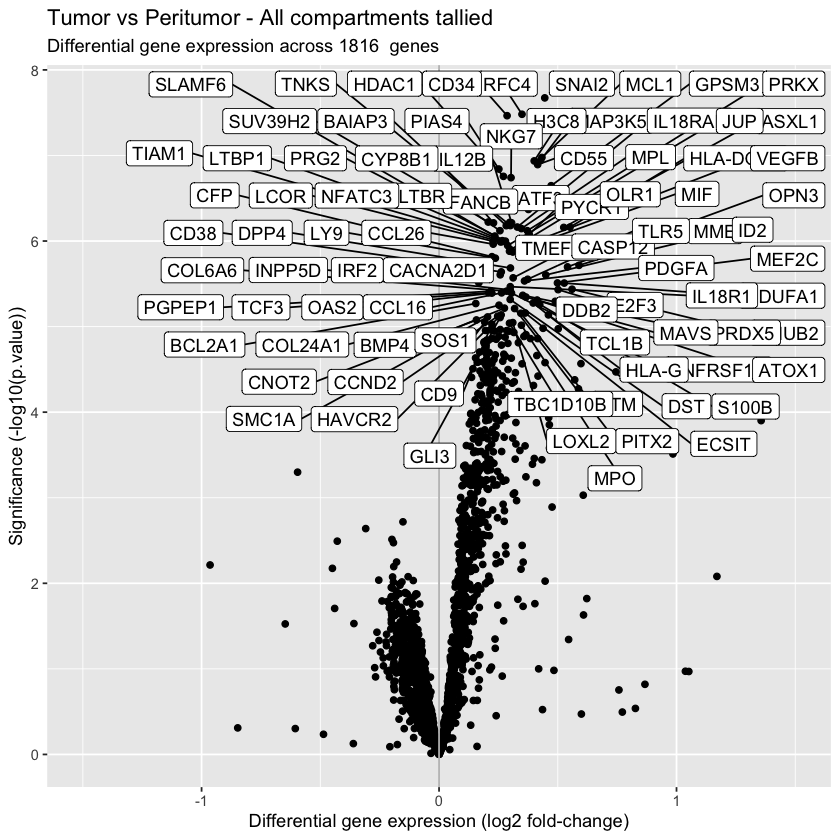

In [12]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 7 ~ str_replace_all(`gene`, ',.*', ''),
            -log10(`P.Value`) > 5 ~ str_replace_all(`gene`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments tallied',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-1.5, 1.5)

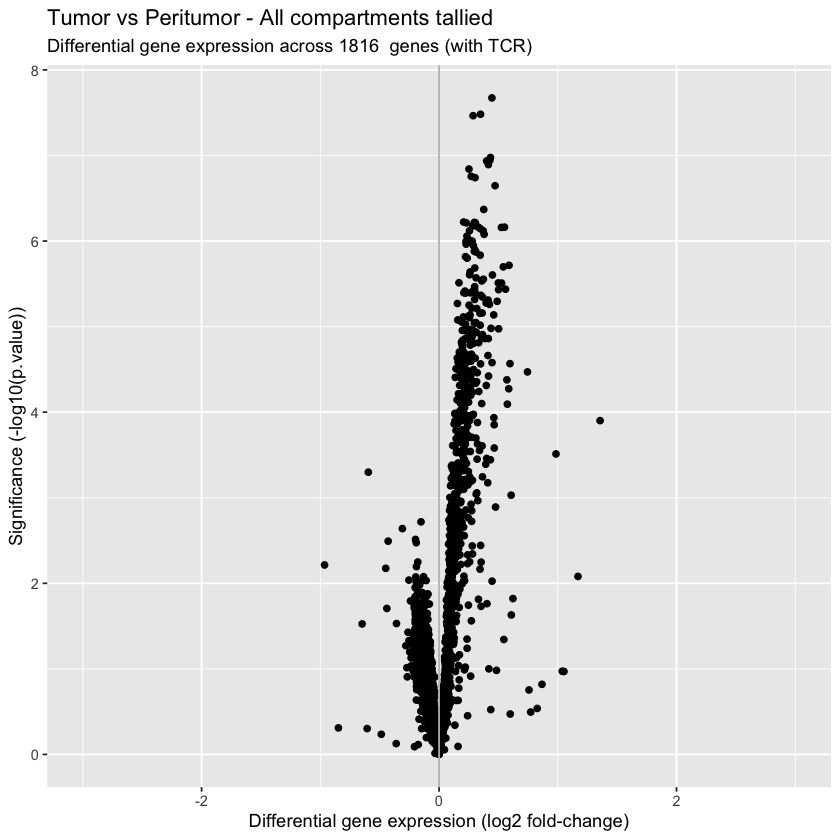

In [13]:
all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% c('TRAJ12', 'TRAJ20', 'TRAJ33', 'TRAV1-2', 'TRBV20-1', 'TRBV6-1') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments tallied',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (with TCR)')
        ) +
        xlim(-3, 3)

In [14]:
all_table %>%
    filter(`logFC` < 0)

gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HLA-A,-0.59565693,9.603282,-5.196638,0.0005025607,0.9126502,-0.1721871
CXCL14,-0.15197841,9.066988,-4.269328,0.0019128726,1.0000000,-1.1715064
TPTE,-0.30881023,9.141863,-4.149388,0.0022944372,1.0000000,-1.6548088
MTF2,-0.19841593,8.957416,-3.960243,0.0030689779,1.0000000,-1.4900895
CD74,-0.42861586,9.339495,-3.929650,0.0032182666,1.0000000,-1.4525687
LAMA1,-0.19206072,9.024427,-3.902968,0.0033547244,1.0000000,-1.6244230
EYA1,-0.17885298,9.138839,-3.573864,0.0056407727,1.0000000,-2.4157677
HLA-C,-0.96425915,8.651185,-3.524463,0.0061052665,1.0000000,-2.2162804
DTX1,-0.19072797,9.078191,-3.496522,0.0063855013,1.0000000,-2.3533904
